In [1]:
# import and set options
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import scipy.stats as stats
import matplotlib as mpl
import sklearn
import utils
mpl.rcParams['pdf.fonttype'] = 42

## Benchmark

This jupyter notebook contains the performance of CHASM2 against other methods by using 7 mutation-level benchmarks (12 methods). We used multiple benchmarks because each individually has weaknesses, but, in aggregate, they span multiple scales of evaluation and amount of supportive evidence (Figure 2a). This is critical because mutations with the most established support for a driver role tend to be in a few well-understood cancer driver genes, but it otherwise would not be clear how generalizable performance would be for mutations in other genes. The benchmarks fall under three broad categories: in vitro experiments, high throughput in vivo screens, and literature-based assessments. We performed evaluations using the area under the Receiver Operating Characteristic Curve (auROC) (Figure 2b, Supplementary Figure 2, Supplementary Table 3), a common metric used in machine learning to describe how well predictions separate two classes without a priori selecting a score threshold, which for many methods is not well defined. In our assessment, the two classes represent likely driver and passenger mutation phenotypes represented by each benchmark. An auROC values of 0.5 is considered random prediction performance. 

#### Utility data

In [2]:
# data needed for formatting
methods = ['VEST', 'CADD', 'Polyphen2_hdiv', 'Polyphen2_hvar', '1-SIFT', 'MutationAssessor', 'REVEL', 'MCAP',
           'ParsSNP', '1-CHASM', 'CHASM2', 'CanDrA', 'CanDrA plus', 'TransFIC', 'FATHMM']
format_benchmark_names = {
    'berger_et_al': 'Berger et al.',
    'berger_et_al_egfr': 'Berger et al. (EGFR)',
    'iarc_tp53': 'IARC TP53',
    'kim_et_al': 'Kim et al.',
    'mc3': 'CGC-recurrent',
    'msk_impact': 'Gene panel (OncoKB)',
    'patrick_et_al': 'Ng et al.'
}

In [3]:
# cancer gene census genes
cgc = utils.process_cgc('CHASM2/data/Census_allSat Jan  7 18-57-49 2017.tsv')

### Kim et al

Kim et al. used a pooled in vivo screen approach by using competition of many mutations within a single pool. Mutations were transduced into HA1E-M cells, and pools were then injected into mice and then later assessed for representation of the mutation. Kim et al subsequently validated 71 alleles, individually, from the screen in NCR-Nu mice. We directly used the annotation of ‘functional’ (positive class) and ‘neutral’ (negative class) from the authors: tumors larger than 500 mm by 130 days as ‘functional’ and remaining mutations as ‘neutral’.

In [4]:
# read the results
df = pd.read_table('CHASM2/data/benchmark/kim_et_al_results.txt')
df['1-CHASM'] = 1-df['CHASM']
df['1-SIFT'] = 1-df['SIFT']
df['-FATHMM'] = -df['FATHMM']

# use the Kim et al. definition of 'functional'
df['y'] = (df['class']=='functional').astype(int)

# calculate chasm2 genome score
rf_df = pd.read_table('CHASM2/data/aggregated_results/PANCAN.txt', usecols=['gene', 'driver score']).drop_duplicates()
df = pd.merge(df, rf_df, left_on='Hugo_Symbol', right_on='gene', how='left')
df['gwCHASM2'] = df['driver score'] * df['CHASM2']

In [6]:
# plot only the top results
compare_df = pd.read_table('CHASM2/data/benchmark/kim_et_al_comparison.txt')
top_methods = utils.top5(compare_df)
other_methods = list(set(methods)-set(top_methods))

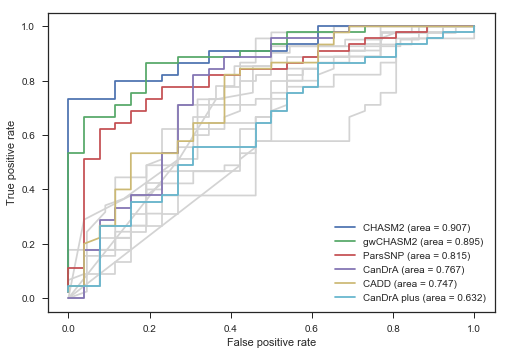

In [7]:
with sns.axes_style('ticks'):
    utils.roc_plot(df, top_methods, other_methods)
    #plt.savefig('figures/benchmark/kim_et_al.pdf')

### Berger et al (tumorplex)

Berger et al. tested a subset of lung adenocarcinoma somatic mutations suspected as likely cancer drivers. We regarded a missense mutation as ‘negative’ for benchmarking if they were labeled ‘neutral’ by the expression-based method (eVIP) and did not appear as a hit in functional assays. The multiplexed xenograft tumorigenesis assay (TumorPlex) used pooled barcoded alleles transduced into SALE-Y cells (an immortalized human lung epithelium cell, sensitized to variants in EGFR/RAS pathway) to assess allele tumor formation capability by comparing barcode representation to pre-injection levels. We used the author defined threshold of a TumorPlex hit to label a mutation as a positive for benchmarking.

In [8]:
# read results
df = pd.read_table('CHASM2/data/benchmark/berger_et_al_results.txt')
df['1-CHASM'] = 1-df['CHASM']
df['1-SIFT'] = 1-df['SIFT']
df['FATHMM'] = -df['FATHMM']
df['y'] = (df['class']=='tumorplex').astype(int)

# calculate chasm2 genome score
rf_df = pd.read_table('CHASM2/data/aggregated_results/PANCAN.txt', 
                      usecols=['gene', 'driver score']).drop_duplicates()
df = pd.merge(df, rf_df, left_on='Hugo_Symbol', right_on='gene', how='left')
df['gwCHASM2'] = df['driver score'] * df['CHASM2']

In [9]:
compare_df = pd.read_table('CHASM2/data/benchmark/berger_et_al_comparison.txt')
top_methods = utils.top5(compare_df)
other_methods = list(set(methods)-set(top_methods))

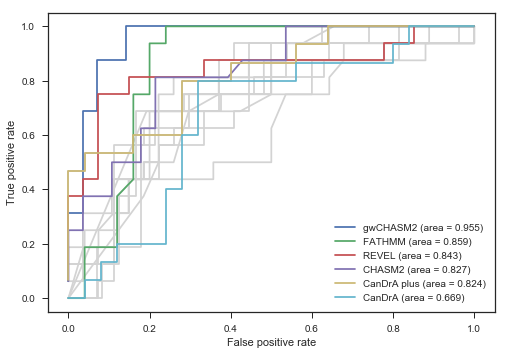

In [10]:
with sns.axes_style('ticks'):
    utils.roc_plot(df, top_methods, other_methods)
    #plt.savefig('figures/benchmark/berger_et_al.pdf')

### Berger et al  (EGFR resistance assay)

The negative mutations were defined in the same way as the TumorPlex assesment above. We benchmarked these neutral mutations against a different assay, an in vitro EGFR resistance assay. This uses an erlotinib-rescue assay using PC9 cells treated at two erlotinib concentrations (300 nM and 3 M), which we required resistance at both concentrations to be labeled a positive. 

In [11]:
df = pd.read_table('CHASM2/data/benchmark/berger_et_al_egfr_results.txt')
df['1-CHASM'] = 1-df['CHASM']
df['1-SIFT'] = 1-df['SIFT']
df['FATHMM'] = -df['FATHMM']
df['y'] = (df['class']=='egfr_resistance').astype(int)

# calculate chasm2 genome score
rf_df = pd.read_table('CHASM2/data/aggregated_results/PANCAN.txt', usecols=['gene', 'driver score']).drop_duplicates()
df = pd.merge(df, rf_df, left_on='Hugo_Symbol', right_on='gene', how='left')
df['gwCHASM2'] = df['driver score'] * df['CHASM2']

In [12]:
compare_df = pd.read_table('CHASM2/data/benchmark/berger_et_al_egfr_comparison.txt')
top_methods = utils.top5(compare_df)
other_methods = list(set(methods)-set(top_methods))

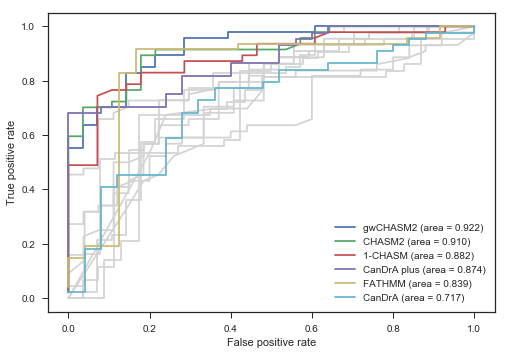

In [13]:
with sns.axes_style('ticks'):
    utils.roc_plot(df, top_methods, other_methods)
    #plt.savefig('figures/benchmark/berger_et_al_egfr_resistance.pdf')

### IARC TP53

We assessed each methods ability to distinguish TP53 mutations with low transactivation (positive class) versus all other TP53 mutations (negative class). We evaluated all missense mutations (n=2,314) for TP53 from the IARC TP53 database. Low transactivation was considered as less than 50% wildtype, as indicated by the median of 8 different targets (WAF1, MDM2, BAX, h1433s, AIP1, GADD45, NOXA, and P53R2).

In [14]:
# read data
df = pd.read_table('CHASM2/data/benchmark/iarc_tp53_results.txt')
df['1-CHASM'] = 1-df['CHASM']
df['1-SIFT'] = 1-df['SIFT']
df['FATHMM'] = -df['FATHMM']

# less than 50% wild type
df['y'] = (df['class']<50).astype(int)

# calculate chasm2 genome scores
rf_df = pd.read_table('CHASM2/data/aggregated_results/PANCAN.txt', usecols=['gene', 'driver score']).drop_duplicates()
df = pd.merge(df, rf_df, left_on='Hugo_Symbol', right_on='gene', how='left')
df['gwCHASM2'] = df['driver score'] * df['CHASM2']

In [15]:
compare_df = pd.read_table('CHASM2/data/benchmark/iarc_tp53_comparison.txt')
top_methods = utils.top5(compare_df)
other_methods = list(set(methods)-set(top_methods))

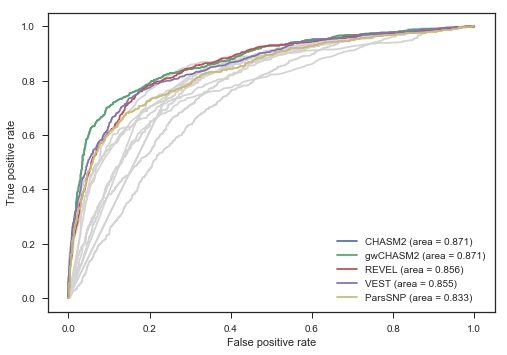

In [16]:
with sns.axes_style('ticks'):
    utils.roc_plot(df, top_methods, other_methods)
    #plt.savefig('figures/benchmark/iarc_tp53.pdf')

### Ng et al (large in vitro assay)

In [17]:
df = pd.read_table('CHASM2/data/benchmark/patrick_et_al_results.txt')
df = df[df['class'].isin(['activating', 'neutral', ])]
df['1-CHASM'] = 1-df['CHASM']
df['1-SIFT'] = 1-df['SIFT']
df['FATHMM'] = -df['FATHMM']

# label activating mutations as positive
df['y'] = (df['class'].isin(['activating',])).astype(int)

# calculate chasm2 genome score
rf_df = pd.read_table('CHASM2/data/aggregated_results/PANCAN.txt', usecols=['gene', 'driver score']).drop_duplicates()
df = pd.merge(df, rf_df, left_on='Hugo_Symbol', right_on='gene', how='left')
df['gwCHASM2'] = df['driver score'] * df['CHASM2']

In [18]:
compare_df = pd.read_table('CHASM2/data/benchmark/patrick_et_al_comparison.txt')
top_methods = utils.top5(compare_df)
other_methods = list(set(methods)-set(top_methods))

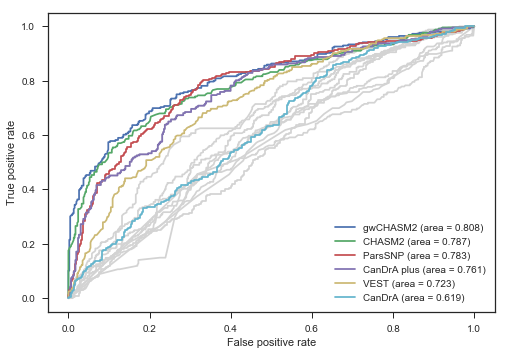

In [19]:
with sns.axes_style('ticks'):
    utils.roc_plot(df, top_methods, other_methods)
    #plt.savefig('figures/benchmark/patrick_et_al.pdf')

### Gene panel (MSK-IMPACT/OncoKB)

We obtained all missense mutations from the MSK-IMPACT gene panel of 414 cancer-related genes {Zehir, 2017 #3}. Mutations were annotated against OncoKB (downloaded 4/3/2017), if the oncogenicity annotation was available for an individual mutation. OncoKB is a literature-backed knowledge base that annotates the cancer driver and actionability status of mutations. We regarded any mutation labeled as ‘Oncogenic’ or ‘Likely Oncogenic’ as the positive class for evaluation with remaining mutations considered as negative.


In [20]:
# read data
df = pd.read_table('CHASM2/data/benchmark/msk_impact_results.txt')
df['class'] = df['class'].fillna('no annotation')
df['1-CHASM'] = 1-df['CHASM']
df['1-SIFT'] = 1-df['SIFT']
df['FATHMM'] = -df['FATHMM']

# either 'oncogenic' or 'likely oncogenic' are positive class
df['y'] = (df['class'].isin(['Oncogenic', 'Likely Oncogenic'])).astype(int)

# calculate chasm2 genome score
rf_df = pd.read_table('CHASM2/data/aggregated_results/PANCAN.txt', usecols=['gene', 'driver score']).drop_duplicates()
df = pd.merge(df, rf_df, left_on='Hugo_Symbol', right_on='gene', how='left')
df['gwCHASM2'] = df['driver score'] * df['CHASM2']

In [21]:
# figure out the top5 methods
compare_df = pd.read_table('CHASM2/data/benchmark/msk_impact_comparison.txt')
top_methods = utils.top5(compare_df)
other_methods = list(set(methods)-set(top_methods))

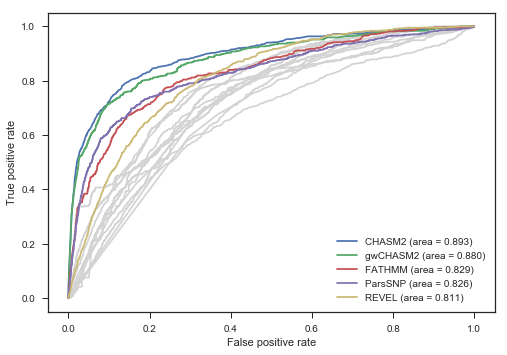

In [22]:
is_missense = df.HGVSp_Short.str.match('^p.[A-Z][0-9]+[A-Z]$').fillna(False)
with sns.axes_style('ticks'):
    utils.roc_plot(df[is_missense], top_methods, other_methods)
    #plt.savefig('figures/benchmark/msk_impact.pdf')

### CGC-recurrent

We examined driver prioritization on an exome-scale through a combined literature/heuristic evaluation. We first obtained a set of curated likely driver genes from the Cancer Gene Census (CGC, COSMIC v79). We restricted to only genes that were labeled as somatic and marked as relevant for missense mutations. We then labeled all recurrent missense mutations (n>1) in CGC genes as the positive class, and remaining mutations as the negative class.


In [23]:
# read results
df = pd.read_table('CHASM2/data/benchmark/mc3_results.txt')
df['1-SIFT'] = 1 - df['SIFT']
df['1-CHASM'] = 1 - df['CHASM']
df['FATHMM'] = -df['FATHMM']

In [24]:
# merge in chasm2 scores
useful_cols = ['UID', 'p.value..0.', 'driver score', 'CHASM2', 'CHASM2_genome', 'CHASM2_pval', 'CHASM2_genome_pval', 'CHASM2_qval', 'CHASM2_genome_qval',]
chasm2_df = pd.read_table('CHASM2/data/aggregated_results/PANCAN.txt', usecols=useful_cols).rename(columns={'driver':'CHASM2'})
df = pd.merge(df, chasm2_df, on='UID', how='left')

In [25]:
# merge in recurrence information
useful_cols = ['Hugo_Symbol', 'HGVSp_Short', 'Protein_position', 'Variant_Classification', 'Tumor_Sample_Barcode', 'CODE']
#mut_df = pd.read_table('data/input.pancan.maf', usecols=useful_cols)
mut_df = pd.read_table('CHASM2/data/aggregated_results/PANCAN.maf')
is_missense = mut_df['Variant_Classification']=='Missense_Mutation'
mut_cts = mut_df[is_missense].groupby(['Hugo_Symbol', 'HGVSp_Short']).size().reset_index(name='recurrence')
df = pd.merge(df, mut_cts, on=['Hugo_Symbol', 'HGVSp_Short'], how='left')

In [26]:
# mark CGC genes
df['CGC'] = 0
df.loc[df.Hugo_Symbol.isin(cgc), 'CGC'] = 1

# define class based on recurrent missense mutations in CGC genes
df['class'] = 'likely neutral'
is_recur_cgc = (df['CGC']==1) & (df['recurrence']>1)
df.loc[is_recur_cgc, 'class'] = 'recurrent'
df['y'] = (df['class']=='recurrent').astype(int)

# rename column
df = df.rename(columns={'CHASM2_genome': 'gwCHASM2'})

In [27]:
# figure out top 5 methods
compare_df = pd.read_table('CHASM2/data/benchmark/mc3_comparison.txt')
top_methods = utils.top5(compare_df)
other_methods = list(set(methods)-set(top_methods))

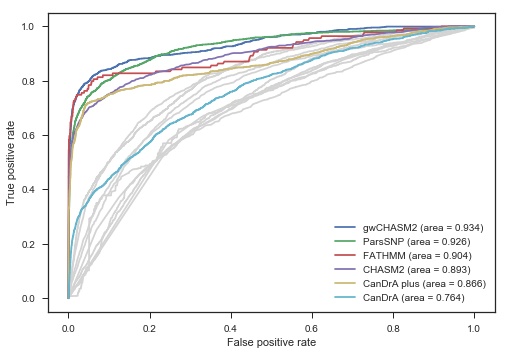

In [28]:
with sns.axes_style('ticks'):
    utils.roc_plot(df, top_methods, other_methods)
    #plt.savefig('figures/benchmark/mc3.pdf')

### Correlation between scores

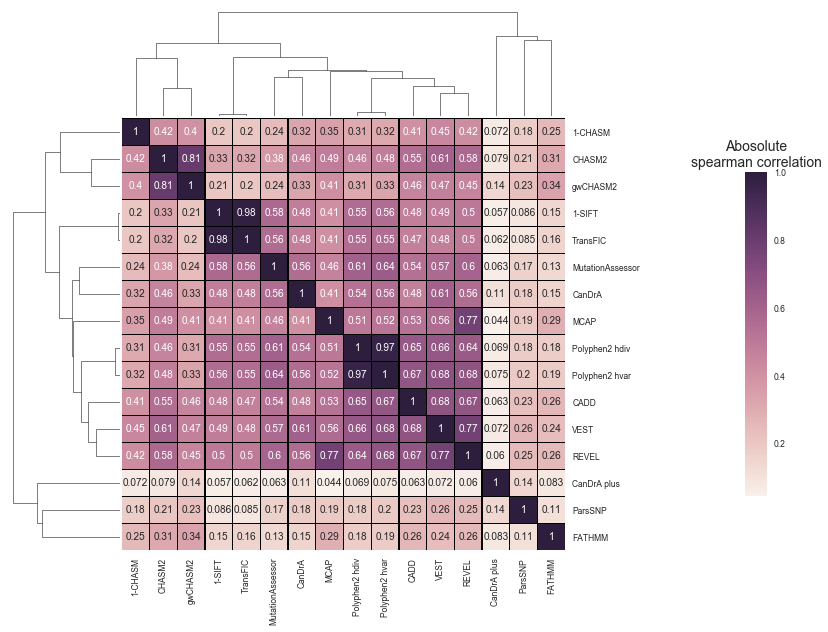

In [39]:
rename_dict = {'CHASM2_genome': 'gwCHASM2', 'Polyphen2_hdiv': 'Polyphen2 hdiv', 'Polyphen2_hvar': 'Polyphen2 hvar'}
method_corr = df[methods+['gwCHASM2']].rename(columns=rename_dict).corr(method='spearman')

with sns.plotting_context('notebook', font_scale=.85):
    c = sns.clustermap(method_corr.abs(), annot=True, linewidth=.25, 
                   linecolor='black',
                   col_cluster=True, row_cluster=True,
                   fmt='.2g'
                  ) 
    _ = plt.setp(c.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
    t = c.fig.axes[-1]
    t.set_title('Abosolute\nspearman correlation', size=14)
    
    # color bar on left
    c.cax.set_position([1.15, .2, .03, .45])
    
    # save figure
    #plt.savefig('figures/mc3_method_correlation.pdf', bbox_inches='tight', bbox_extra_artists=[c.cax])

### Overall benchmark performance

#### Process results

In [33]:
# read the auROC comparisons
auc_dict = {}
pval_dict = {}
rank_dict = {}
for f in glob.glob('CHASM2/data/benchmark/*_comparison.txt'):
    bench_name = os.path.basename(f)[:-15]
    tmp = pd.read_table(f)
    auc_dict[bench_name] = tmp['auc']
    pval_dict[bench_name] = tmp['pvalue']
    
    # figure out ranking
    polyphen_methods = ['Polyphen2_hvar', 'Polyphen2_hdiv']
    is_polyphen = tmp.method.isin(polyphen_methods)
    worst_polyphen = tmp.loc[is_polyphen, 'auc'].idxmin()
    chasm2_methods = ['CHASM2', 'gwCHASM2']
    is_chasm2 = tmp.method.isin(chasm2_methods)
    worst_chasm2 = tmp.loc[is_chasm2, 'auc'].idxmin()
    candra_methods = ['CanDrA', 'CanDrA.plus']
    is_candra = tmp.method.isin(candra_methods)
    worst_candra = tmp.loc[is_candra, 'auc'].idxmin()
    worst_methods = [worst_polyphen, worst_chasm2, worst_candra]
    rank_dict[bench_name] = tmp[~tmp.method.isin(worst_methods)]['auc'].rank(ascending=False)

# store the various metrics
auc_df = pd.DataFrame(auc_dict).T
pval_df = pd.DataFrame(pval_dict).T
rank_df = pd.DataFrame(rank_dict).T

In [34]:
# create a "best" column for chasm2, polyphen2, and candra
rank_df['CHASM2 (best)'] = rank_df.loc[:, chasm2_methods].min(axis=1)
rank_df['Polyphen2 (best)'] = rank_df.loc[:, polyphen_methods].min(axis=1)
rank_df['CanDrA (best)'] = rank_df.loc[:, candra_methods].min(axis=1)
pval_df['CHASM2 (best)'] = pval_df.loc[:, chasm2_methods].min(axis=1)
pval_df['Polyphen2 (best)'] = pval_df.loc[:, polyphen_methods].min(axis=1)
pval_df['CanDrA (best)'] = pval_df.loc[:, candra_methods].min(axis=1)
auc_df['CHASM2 (best)'] = auc_df.loc[:, chasm2_methods].max(axis=1)
auc_df['Polyphen2 (best)'] = auc_df.loc[:, polyphen_methods].max(axis=1)
auc_df['CanDrA (best)'] = auc_df.loc[:, candra_methods].max(axis=1)

# calculate the mean auc and mean rank across benchmarks
cols_of_interest = [u'1-CHASM', u'1-SIFT', u'CADD', u'FATHMM', u'MCAP', u'MutationAssessor', u'ParsSNP', 'TransFIC',
                    u'REVEL', u'VEST', u'CHASM2 (best)', u'Polyphen2 (best)', u'CanDrA (best)']
mean_auc = auc_df.mean()[cols_of_interest]
mean_rank = rank_df.mean()[cols_of_interest]
mean_auc.sort_values(inplace=True, ascending=False)

#### Heatmap

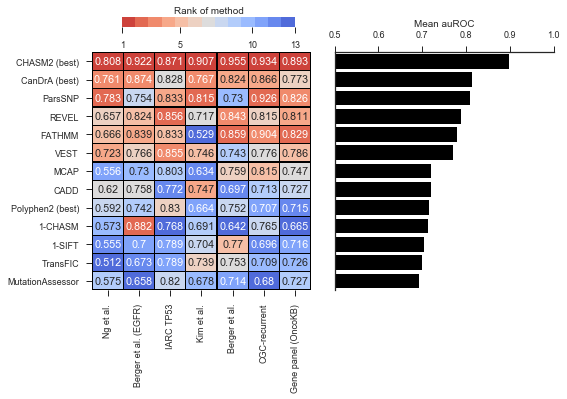

In [36]:
from matplotlib.colors import ListedColormap
with sns.axes_style('ticks'), sns.plotting_context('notebook', font_scale=.9):
    # create side-by-side subplots
    fig, axes = plt.subplots(1, 2)
    
    # prepare data for heatmap
    bench_order = ['patrick_et_al', 'berger_et_al_egfr', 'iarc_tp53', 'kim_et_al', 'berger_et_al', 'mc3', 'msk_impact']
    auc_plot = auc_df[cols_of_interest].T.fillna(.5).loc[mean_auc.index, bench_order]
    rank_plot = auc_df[cols_of_interest].T.rank(ascending=False).fillna(13).loc[mean_auc.index, bench_order]
    
    # plot heatmap
    cbar_ax = fig.add_axes([.22, .95, .3, .025])
    coolwarm = sns.color_palette('coolwarm', 13).as_hex()[::-1]
    coolwarm_cmap = ListedColormap(coolwarm)
    hm = sns.heatmap(rank_plot.rename(columns=format_benchmark_names), 
                     cmap=coolwarm_cmap,
                     annot=auc_plot,
                     fmt='.3g',
                     linewidth=.25,
                     linecolor='black',
                     ax=axes[0],
                     cbar_ax=cbar_ax,
                     cbar_kws={'orientation':'horizontal', 'ticks': [1, 5, 10, 13]})
                     #cbar_ax=cbar_ax, ax=ax,)
    cbar_ax.set_xlabel('Rank of method')
    cbar_ax.xaxis.set_label_position('top')

    # create a colored annotation bar for the different benchmarks
    #row_bar_ax = cbar_ax = fig.add_axes([.17, .00, .385, .025])
    #vals = [[0, 0, 0, 1, 1, 2, 2]]
    #reg_pal = sns.color_palette().as_hex()
    #my_cmap = ListedColormap([reg_pal[1], reg_pal[4], reg_pal[5]])
    #sns.heatmap(vals, cmap=my_cmap, ax=row_bar_ax, cbar=False, linecolor='black', linewidth=.25)

    # bar plot of mean auROC
    ax = axes[1]
    sns.barplot(mean_auc, mean_auc.index, color='black', ax=ax)
    ax.set_xlim(0.5, 1)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.yaxis.set_label_position('right')
    ax.yaxis.set_ticks_position('left')
    ax.set_xlabel('Mean auROC')
    sns.despine(right=True, bottom=True, top=False, ax=ax)
    
    # save figure
    plt.tight_layout()
    #plt.savefig('figures/mutation_benchmark_overview_heatmap_v4.pdf')

#### Create supplementary table 3

In [37]:
# prep dataframe marking significance with asterisks
pval_asterisk = pval_df[cols_of_interest].copy()
pval_asterisk.loc[:, :] = ''
pval_asterisk[pval_df<0.05] = '*'
pval_asterisk[pval_df<0.01] = '**'
pval_asterisk[pval_df<0.001] = '***'

# create supp table
formatted_auc = auc_df[cols_of_interest].applymap('{:.3g}'.format)
formatted_pval = pval_df[cols_of_interest].applymap('{:.1g}'.format)
supp_table_df = formatted_auc + pval_asterisk + " (" + formatted_pval + ")"

# rename columns to be more readable

supp_table_df = supp_table_df.T[bench_order].rename(columns=format_benchmark_names).loc[mean_auc.index]

# save table
#supp_table_df.to_csv('results/supplementary_table_3_mutation_benchmark.txt', sep='\t')

# show dataframe in notebook
supp_table_df

,Ng et al.,Berger et al. (EGFR),IARC TP53,Kim et al.,Berger et al.,CGC-recurrent,Gene panel (OncoKB)
CHASM2 (best),0.808 (1),0.922 (1),0.871 (1),0.907 (1),0.955 (1),0.934 (1),0.893 (1)
CanDrA (best),0.761** (0.007),0.874 (0.2),0.828*** (3e-08),0.767* (0.02),0.824 (0.05),0.866*** (1e-40),0.773*** (8e-47)
ParsSNP,0.783* (0.05),0.754** (0.001),0.833*** (2e-07),0.815* (0.03),0.73** (0.002),0.926** (0.001),0.826*** (7e-14)
REVEL,0.657*** (4e-11),0.824 (0.06),0.856* (0.02),0.717** (0.002),0.843 (0.1),0.815*** (2e-103),0.811*** (3e-27)
FATHMM,0.666*** (2e-10),0.839 (0.2),0.833*** (1e-06),0.529*** (6e-10),0.859 (0.1),0.904*** (8e-05),0.829*** (4e-16)
VEST,0.723*** (3e-05),0.766** (0.004),0.855* (0.03),0.746** (0.007),0.743** (0.008),0.776*** (3e-170),0.786*** (3e-39)
MCAP,0.556*** (1e-21),0.73** (0.01),0.803*** (2e-17),0.634*** (0.0002),0.759* (0.01),0.815*** (3e-88),0.747*** (2e-67)
CADD,0.62*** (3e-15),0.758* (0.03),0.772*** (3e-25),0.747** (0.007),0.697** (0.004),0.713*** (7e-237),0.727*** (2e-75)
Polyphen2 (best),0.592*** (3e-19),0.742** (0.01),0.83*** (1e-15),0.664*** (8e-07),0.752** (0.006),0.707*** (3e-255),0.715*** (6e-100)
1-CHASM,0.573*** (3e-18),0.882 (0.4),0.768*** (6e-30),0.691*** (0.0007),0.642*** (0.0004),0.765*** (1e-111),0.665*** (5e-86)
